# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="./Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [ ]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    print("Shape of states is {}".format(states.shape))
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    episode_len = 0
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        episode_len += 1
        if np.any(dones):                                  # exit loop if episode finished
            print("Count is {}".format(episode_len))
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Implement Actor policy
class Actor(nn.Module):
    def __init__(self, state_size, action_size, hidden1=256, hidden2=256):
        super(Actor, self).__init__()
        
        # Two hidden layers as specified in DDPG paper. Unlike the DDPG
        # paper, don't use batch norm
        self.fc1 = nn.Linear(state_size, hidden1)
        torch.nn.init.uniform_(self.fc1.weight, -1.0/np.sqrt(state_size), 1.0/np.sqrt(state_size))

        self.fc2 = nn.Linear(hidden1, hidden2)
        torch.nn.init.uniform_(self.fc1.weight, -1.0/np.sqrt(hidden1), 1.0/np.sqrt(hidden1))

        # Create an output layer for the actions
        self.action = nn.Linear(hidden2, action_size)
        torch.nn.init.uniform_(self.action.weight, -3e-3, 3e-3)
 
    def forward(self, state):
        x = F.leaky_relu(self.fc1(state))
        x = F.leaky_relu(self.fc2(x))

        # Use a tanh layer to bound the actions
        return torch.tanh(self.action(x))
    
# Implement Critic policy
class Critic(nn.Module):
    def __init__(self, state_size, action_size, hidden1=256, hidden2=256):
        super(Critic, self).__init__()

        # Two hidden layers as specified in DDPG paper. Unlike the DDPG
        # paper, include actions in the input layer and don't use batch norm
        self.fc1 = nn.Linear(state_size + action_size, hidden1)
        torch.nn.init.uniform_(self.fc1.weight,
                               -1.0/np.sqrt(state_size + action_size),
                               1.0/np.sqrt(state_size + action_size))

        self.fc2 = nn.Linear(hidden1, hidden2)
        torch.nn.init.uniform_(self.fc2.weight, -1.0/np.sqrt(hidden1), 1.0/np.sqrt(hidden1))

        # Output layer for the value
        self.value = nn.Linear(hidden2, 1)
        torch.nn.init.uniform_(self.value.weight, -3e-3, 3e-3)

    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return self.value(x)

In [6]:
# Based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

### 5. MADDPG

Implement the MADDPG algorithm

In [7]:
from collections import deque
import random
import copy
import torch.optim as optim
from tensorboardX import SummaryWriter

BATCH_SIZE=128

class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
        
    def add(self, state, action, reward, done, next_state):
        self.buffer.append((state, action, reward, done, next_state))
        
    def sample(self, size):
        s = random.sample(self.buffer, k=size)
        states = np.array([_[0] for _ in s])
        actions = np.array([_[1] for _ in s])
        rewards = np.array([_[2] for _ in s])
        dones = np.array([_[3] for _ in s])
        next_states = np.array([_[4] for _ in s])

        return states, actions, rewards, dones, next_states
        
    def __len__(self):
        return len(self.buffer)

class Agent:
    def __init__(self, state_size, action_size):
        # Construct the actor and critic networks
        self.actor = Actor(state_size, action_size)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.0001)
        self.critic = Critic(2*state_size, action_size)
        # Don't use weight decay for critic optimizer. It didn't seem to help
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.001)

        # Construct the target networks
        self.target_actor = copy.deepcopy(self.actor)
        self.target_actor.eval()
        self.target_critic = copy.deepcopy(self.critic)
        self.target_critic.eval()
        
    def target_value(self, x, actions):
        with torch.no_grad():
            qvalue = self.target_critic(x, actions)
        return qvalue

    def target_actions(self, obs):
        with torch.no_grad():
            result = self.target_actor(obs)
        return result
    
    def update_critic(self, y, x, actions):
        value = self.critic(x, actions)
        loss = F.mse_loss(value, y)
        self.critic_optimizer.zero_grad()
        loss.backward()
        self.critic_optimizer.step()
        return loss
    
    def update_actor(self, x, obs):
        loss = -torch.mean(self.critic(x, self.actor(obs)))
        self.actor_optimizer.zero_grad()
        loss.backward()
        self.actor_optimizer.step()
        return loss
        
    def act(self, obs):
        self.actor.eval()
        with torch.no_grad():
            result = self.actor(torch.from_numpy(obs)).numpy()
        self.actor.train()
        return result
    
def update_target(model, target, tau):
    # Do a "soft" update of the target model trainable parameters
    for target_param, param in zip(target.parameters(), model.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)
    
class MADDPG:
    def __init__(self, state_size, action_size, num_agents):
        self.replay = ReplayBuffer(int(1e6))    
        self.agents = [Agent(state_size, action_size) for _ in range(num_agents)]
        self.writer = SummaryWriter()
        self.iter = 0
        
    def __del__(self):
        # export scalar data to JSON for external processing
        self.writer.export_scalars_to_json("./all_scalars.json")
        self.writer.close()
        
    def act(self, obs):
        """
        For each agent select action according to current policy
        
        Args:
            param1 (np.array) obs: Observation state of environment
            
        Returns:
            np.array: actions determined by the policy
        """
        # For each agent select action according to current policy. The
        # actor and critic both get passed the concatenated environment
        # state, which helps offset the inherent non-stationarity of the
        # environment
        return np.stack([agent.act(obs[i]).squeeze()
                         for i, agent in enumerate(self.agents)])

    def train(self, gamma, tau):
        """
        Train each agent using a random minibatch of samples from the
        replay buffer
        
        Args:
            param1 (float) gamma: The discount factor to use
            param2 (float) tau: The value to use for soft target updates
        """
        for i, agent in enumerate(self.agents):
            # Sample a random minibatch
            obs, actions, rewards, dones, next_obs = self.replay.sample(BATCH_SIZE)
            
            # Convert to PyTorch tensors
            obs = torch.from_numpy(obs)
            x = torch.reshape(obs, (BATCH_SIZE, -1))
            actions = torch.from_numpy(actions)
            rewards = torch.from_numpy(rewards.astype(np.float32))[:, i].unsqueeze(1)
            dones = torch.from_numpy(dones.astype(np.uint8))[:, i].unsqueeze(1).float()
            next_obs = torch.from_numpy(next_obs)
            next_x = torch.reshape(next_obs, (BATCH_SIZE, -1))
            
            # Compute the actions associated with the next observations and
            # the estimated action value and target (y)
            next_actions = agent.target_actions(next_obs[:,i,:])
            value = agent.target_value(next_x, next_actions)
            y = rewards + gamma*value*(1 - dones)
            
            # Update the critic and actor
            critic_loss = agent.update_critic(y, x, actions[:,i,:])
            self.writer.add_scalar('data/critic_{}_loss'.format(i+1), critic_loss, self.iter)  
            actor_loss = agent.update_actor(x, obs[:,i,:])
            self.writer.add_scalar('data/actor_{}_loss'.format(i+1), actor_loss, self.iter)     
            
            # Update target network parameters
            self.soft_update(agent.critic, agent.target_critic, tau)
            self.soft_update(agent.actor, agent.target_actor, tau)
            
        self.iter += 1
            
    def soft_update(self, model, target, tau):
        # Do a "soft" update of the target model trainable parameters
        for target_param, param in zip(target.parameters(), model.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)
            
    def hard_update(self, model, target):
        target.load_state_dict(model.state_dict())
        
    def save(self):
        torch.save(self.agents[0].actor.state_dict(), 'agent_1_actor_checkpoint.pth')
        torch.save(self.agents[0].critic.state_dict(), 'agent_1_critic_checkpoint.pth')
        torch.save(self.agents[1].actor.state_dict(), 'agent_2_actor_checkpoint.pth')
        torch.save(self.agents[1].critic.state_dict(), 'agent_2_critic_checkpoint.pth')

In [8]:
import progressbar as pb

RANDOM_SEED=627

def learn(maddpg, num_episodes, max_episode_len=750, gamma=0.99, tau=0.001, noise_std=0.5, warmup=500):
    steps = 0
    progress = pb.ProgressBar()    
    scores = []                         # maximum reward across the agents per episode
    rewards_buffer = deque(maxlen=100)  # rolling buffer for episode rewards
    
    for episode in progress(range(num_episodes)):
        episode_len = 0
        total_rewards = np.zeros(num_agents)
        action_noises = [OrnsteinUhlenbeckActionNoise(mu=np.array((0.0, 0.0)),
                                                      sigma=np.array((noise_std, noise_std)),
                                                      theta=0.15)
                         for _ in range(num_agents)]
        
        # Track decay of action noise in tensorboard
        maddpg.writer.add_scalar('data/noise_std', noise_std, episode)
        
        # Reset observation and receive initial observation state
        env_info = env.reset(train_mode=True)[brain_name]
        obs = np.asarray(env_info.vector_observations, dtype=np.float32)
        
        while True:
            # Execute action a_t and observe reward r_t and new state s_{t+1}
            if steps < warmup:
                actions = np.random.uniform(-1.0, 1.0, (num_agents, action_size)).astype(np.float32)
            else:
                actions = maddpg.act(obs)
                for action, noise in zip(actions, action_noises):
                    action += noise().astype(np.float32)
                actions = np.clip(actions, -1, 1)

            env_info = env.step(actions)[brain_name]

            # Get the reward and next state
            rewards = env_info.rewards
            total_rewards += rewards
            next_obs = np.asarray(env_info.vector_observations, dtype=np.float32)
            dones = env_info.local_done
            
            # Store transitions (s_t, a_t, r_t, s_{t+1}) in replay buffer
            maddpg.replay.add(obs, actions, rewards, dones, next_obs)
            obs = next_obs
            steps += 1
            
            # Update the policies
            if steps > 1024:
                maddpg.train(gamma, tau)
                    
            episode_len += 1
            if np.any(dones) or episode_len >= max_episode_len:
                break
        
        # Episode is done or reached maximum timesteps
        scores.append(max(total_rewards))
        rewards_buffer.append(max(total_rewards))
        maddpg.writer.add_scalar('data/episode_length', episode_len, episode)
        maddpg.writer.add_scalar('data/episode_reward', max(total_rewards), episode)
        noise_std = max(0.03, noise_std*0.995)  # exponential decay of action noise

        if np.mean(rewards_buffer) >= 0.5:
            progress.finish()
            print("\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}" \
                  .format(episode - 100, np.mean(rewards_buffer)))
            # Save the models
            maddpg.save()
            break
     
    return scores

random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
maddpg = MADDPG(state_size, action_size, num_agents)
scores = learn(maddpg, 7500, gamma=0.99, tau=0.005, warmup=0)

100% (7500 of 7500) |####################| Elapsed Time: 1:01:46 Time:  1:01:46



Environment solved in 5757 episodes!	Average Score: 0.50


### 6. Plot the rewards

Plot the training progress over time

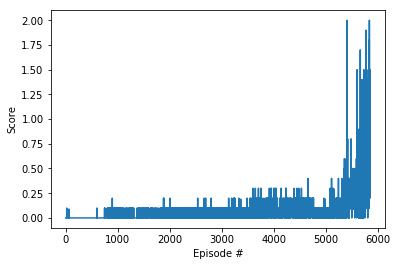

In [9]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
fig.savefig('training.pdf', bbox_inches='tight')

### 7. Play an episode

In [10]:
maddpg.agents[0].actor.eval()
maddpg.agents[1].actor.eval()
for i in range(1, 16):                                      # play game for 15 episodes
    env_info = env.reset(train_mode=False)[brain_name]
    obs = np.asarray(env_info.vector_observations, dtype=np.float32)
    while True:
        actions = maddpg.act(obs)
        env_info = env.step(actions)[brain_name]           # send all actions to the environment
        obs = np.asarray(env_info.vector_observations, dtype=np.float32)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        if np.any(dones):                                  # exit loop if episode finished
            break

In [ ]:
env.close()